# PART 3: Convexity Correction

### Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.stats import norm
from scipy.interpolate import CubicSpline

import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 8

# <a id = "top">Contents</a>
# [1. Value CMS Products](#p1)
# [2. Convexity Correction](#p2)

# <a id = "p1"> <font color = "green">1. Value CMS Products [(back to contents)](#top)

#### CMS Formula

For static replication of any constant maturity swap (CMS) payoff $g(F) = F$, $F$ is the swap rate, a CMS contract paying can be expressed as
  \begin{equation*}
    \begin{split}
      D(0,T) F + \int_0^F h''(K) V^{rec}(K) dK + \int_F^\infty h''(K) V^{pay}(K) dK
    \end{split}
  \end{equation*}

Where
  
  \begin{equation*}
    \begin{split}
      h(K) &= \frac{g(K)}{\mbox{IRR}(K)} \\
      h'(K) &= \frac{\mbox{IRR}(K)g'(K) - g(K)\mbox{IRR}'(K)}{\mbox{IRR}(K)^2} \\
      h''(K) &= \frac{\mbox{IRR}(K)g''(K)-\mbox{IRR}''(K)g(K) -2\cdot\mbox{IRR}'(K)g'(K)}{\mbox{IRR}(K)^2} \\
      &\;\;\;\;\;\;\;\;\;\;+
      \frac{2\cdot\mbox{IRR}'(K)^2g(K)}{\mbox{IRR}(K)^3}.
    \end{split}
  \end{equation*}

For CMS rate payment, the derivatives are:

\begin{equation*}
\begin{split}
g(K) &= K \\
g'(K) &= 1 \\
g''(K) &= 0
\end{split}
\end{equation*}

Let $m$ denote the payment frequence ($m=2$ for semi-annual payment frequency), and let $N = T_N-T_n$ denote the tenor of the swap (number of years), the partial derivatives on the IRR function $\mbox{IRR}(S)$ given by:
\begin{equation*}
\begin{split}
\mbox{IRR}(K)&=\sum_{i=1}^{N\times m}\frac{1}{(1+\frac{K}{m})^i}=\frac{1}{K}\left[1-\frac{1}{\left(1+\frac{K}{m}\right)^{N\times m}}\right]\\
\mbox{IRR}'(K)&=-\frac{1}{K}\mbox{IRR}(K)
+\frac{1}{m\times K}\frac{N\times m}{\left(1+\frac{K}{m}\right)^{N\times m+1}} \\
\mbox{IRR}''(K)&=-\frac{2}{K}\mbox{IRR}'(K)
-\frac{1}{m^2\times K}\frac{N\times m\cdot (N\times m+1)}{\left(1+\frac{K}{m}\right)^{N\times m+2}} \\
\end{split}
\end{equation*}

In [4]:
def g_0(K):
    return K

def g_1(K):
    return 1.0

def g_2(K):
    return 0.0

def IRR_0(K, m, tenor):
    # Implementation of IRR(K) function
    value = 1/K * ( 1.0 - 1/(1 + K/m)**(tenor*m) )
    return value

def IRR_1(K, m, tenor):
    # Implementation of IRR'(K) function (1st derivative)
    firstDerivative = -1/K*IRR_0(K, m, tenor) + 1/(K*m)*tenor*m/(1+K/m)**(tenor*m+1)
    return firstDerivative

def IRR_2(K, m, tenor):
    # Implementation of IRR''(K) function (2nd derivative)
    secondDerivative = -2/K*IRR_1(K, m, tenor) - 1/(K*m*m)*(tenor*m)*(tenor*m+1)/(1+K/m)**(tenor*m+2)
    return secondDerivative

def h_0(K, m, tenor):
    # implementation of h(K)
    value = g_0(K) / IRR_0(K, m, tenor)
    return value

def h_1(K, m, tenor):
    # implementation of h'(K) (1st derivative)
    firstDerivative = (IRR_0(K, m, tenor)*g_1(K) - g_0(K)*IRR_1(K, m, tenor)) / IRR_0(K, m, tenor)**2
    return firstDerivative

def h_2(K, m, tenor):
    # implementation of h''(K) (2nd derivative)
    secondDerivative = ((IRR_0(K, m, tenor)*g_2(K) - IRR_2(K, m, tenor)*g_0(K) - 2.0*IRR_1(K, m, tenor)*g_1(K))/IRR_0(K, m, tenor)**2 
                        + 2.0*IRR_1(K, m, tenor)**2*g_0(K)/IRR_0(K, m, tenor)**3)
    return secondDerivative

#### Use the SABR model in the part 2

We will also need to implement the IRR-settled payer and receiver swaption formulae:

  \begin{equation*}
    \begin{split}
      V^{pay}_{n,N}(0) &= D(0,T_n) \cdot \mbox{IRR}(S_{n,N}(0)) \cdot \mbox{Black76Call}(S_{n,N}(0),K,\sigma_{n,N},T) \\
      V^{rec}_{n,N}(0) &= D(0,T_n) \cdot \mbox{IRR}(S_{n,N}(0)) \cdot \mbox{Black76Put}(S_{n,N}(0),K,\sigma_{n,N},T) \\
    \end{split}
  \end{equation*}

where $S_{n,N}(0)=F$ is today's forward swap rate calculated based on the curves we bootstrapped, and $\sigma_{n,N}$ is the SABR implied volatility calibrated to swaption market data.

In [5]:
## Import IRS Data
raw_data = pd.read_excel("IRS_data_final.xlsx")

## Import the SABR parameters in Part 2
Alpha = pd.read_excel('Part2_SABR.xlsx',sheet_name = 'Alpha')
Rho = pd.read_excel('Part2_SABR.xlsx',sheet_name = 'Rho')
Nu = pd.read_excel('Part2_SABR.xlsx',sheet_name = 'Nu')

In [6]:
## Linear interpolate Libor DF
def LIBORDF(T, df = raw_data):
    x = list(df['Tenor'])
    y = list(df['LIBOR_DF'])
    return np.interp(T, x, y)

## Linear interpolate OIS DF
def OISDF(T, df = raw_data):
    x = list(df['Tenor'])
    y = list(df['ON_DF'])
    return np.interp(T, x, y)

def Forward_LIBOR(m, D1, D2):
    return m * ((D1 - D2) / D2)

## Calculate swap rate
def Forward_Swap_Rate(expiry, tenor, m):
    floated, fix = 0, 0
    for i in range(1, int(tenor * m)+1):
        end = expiry + i/m
        floated += OISDF(end) * Forward_LIBOR(m, LIBORDF(end-1/m), LIBORDF(end)) * 1/m
        fix += OISDF(expiry + i/m)/m
    return floated/fix

## Calculate the SABR implied volatitlity
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

# Linear interpolate SABR parameters
def ParameterInterp (dataframe, tenor, expiry):
    linear_interp = []
    new_paras = []
    for i in [1,2,3,5,10]:
        linear_interp.append(np.interp(tenor, [1, 5, 10], dataframe[i]))
    for i in range(5):
        new_paras.append(linear_interp[i])
    result = np.interp(expiry, [1, 2, 3, 5, 10], new_paras)
    return float(result)

## Black 76 pricing formula
def black76_payer(F, K, t, sigma):
    d1 = (np.log(F/K)+(1/2)*(sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    price = F*norm.cdf(d1) - K*norm.cdf(d2)
    return price

def black76_receiver(F, K, t, sigma):
    d1 = (np.log(F/K)+1/2*(sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    price = K*norm.cdf(-d2) - F*norm.cdf(-d1)
    return price

## IRR-Settled payer and recevier swaption integrant at time T
def Rec_Integral(F, K, m, tenor, t, sigma):
    return h_2(K, m, tenor) * black76_receiver(F, K, t, sigma)

def Pay_Integral(F, K, m, tenor, t, sigma):
    return h_2(K, m, tenor) * black76_payer(F, K, t, sigma)

## Calculate the CMS rate
def CMS(m, tenor, expiry):
    F = Forward_Swap_Rate(expiry, tenor, m)
    alpha = ParameterInterp(Alpha, tenor, expiry)
    rho = ParameterInterp(Rho, tenor ,expiry)
    nu = ParameterInterp(Nu, tenor ,expiry)
    CMS = F + quad(lambda x: Rec_Integral(F, x, m, tenor ,expiry, SABR(F,x,expiry,alpha,0.9,rho,nu)), 0, F)[0]\
            + quad(lambda x: Pay_Integral(F, x, m, tenor ,expiry, SABR(F,x,expiry,alpha,0.9,rho,nu)), F, 0.1)[0]
    return CMS

## Calculate the CMS rate
def new_CMS(m, tenor, expiry):
    F = Forward_Swap_Rate(expiry, tenor, m)
    alpha = ParameterInterp(Alpha, tenor, expiry)
    rho = ParameterInterp(Rho, tenor ,expiry)
    nu = ParameterInterp(Nu, tenor ,expiry)
    CMS = F + quad(lambda x: Rec_Integral(F, x, m, tenor ,expiry, SABR(F,x,expiry,alpha,0.9,rho,nu)), 0, F)[0]\
            + quad(lambda x: Pay_Integral(F, x, m, tenor ,expiry, SABR(F,x,expiry,alpha,0.9,rho,nu)), F, 0.1)[0]
    return F, CMS

## Calculate the leg of CMS
def PV_CMS(m, tenor, expiry):
    n = int(expiry*m)
    pv = 0
    for i in range(1,n+1):
        ti = i/m
        pv += (OISDF(ti)/m) * CMS(m, tenor, expiry)
    return pv

In [7]:
def ParameterInterp (dataframe, tenor, expiry):
    linear_interp = []
    new_paras = []
    for i in [1,2,3,5,10]:
        linear_interp.append(np.interp(tenor, [1, 5, 10], dataframe[i]))
    for i in range(5):
        new_paras.append(linear_interp[i])
    result = np.interp(expiry, [1, 2, 3, 5, 10], new_paras)
    return float(result)

#### CMS 10y semi-annually over the next 5 years

In [8]:
tenor = 10
expiry = 5
m = 2
print('PV of a leg receiving CMS10y semi-annually over the next 5 years is ', PV_CMS(m, tenor, expiry))

PV of a leg receiving CMS10y semi-annually over the next 5 years is  0.21871580641301414


#### CMS 2y quarterly over the next 10 years

In [9]:
tenor1 = 2
expiry1 = 10
m1 = 4
print('PV of a leg receiving CMS2y quarterly over the next 10 years = ', PV_CMS(m1, tenor1, expiry1))

PV of a leg receiving CMS2y quarterly over the next 10 years =  0.4317789721229599


# <a id = "p2"> <font color = "green">2. Convexity Correction [(back to contents)](#top)

CMS rate = $E^T[S_{n,N}(T)]$
\begin{equation*}
    \begin{split}
      \mbox{E}^T[S_{n,N}(T)]&=F + \frac{1}{D(0,T)}[\int_0^F h''(K) V^{rec}(K) dK + \int_F^\infty h''(K) V^{pay}(K) dK]
    \end{split}
  \end{equation*}

Where
\begin{equation*}
\begin{split}
h''(K) &= \frac{\mbox{-IRR''}(K)\cdot K-2\cdot\mbox{IRR}'(K)\cdot K}{\mbox{IRR}(K)^2} + \frac{2\cdot\mbox{IRR}'(K)^2 \cdot K}{\mbox{IRR}(K)^3}
 \end{split}
    \end{equation*}

In [11]:
P1_forward_rate=[]
forward_rate=[]
CMS_rate=[]

for i in [1, 5, 10]:
    for j in [1, 2, 3, 5, 10]:
        fr_rate, cms_rate=new_CMS(2,j, i)
        forward_rate.append(fr_rate)
        CMS_rate.append(cms_rate)

df_new_CMS = pd.DataFrame([['1Y', '1Y'],
                                 ['1Y', '2Y'],
                                 ['1Y', '3Y'],
                                 ['1Y', '5Y'],
                                 ['1Y', '10Y'],
                                 ['5Y', '1Y'],
                                 ['5Y', '2Y'],
                                 ['5Y', '3Y'],
                                 ['5Y', '5Y'],
                                 ['5Y', '10Y'],
                                 ['10Y', '1Y'],
                                 ['10Y', '2Y'],
                                 ['10Y', '3Y'],
                                 ['10Y', '5Y'],
                                 ['10Y', '10Y']],
                                 columns = ['Start', 'Tenor'])

df_new_CMS["Forward Rate"]=forward_rate
df_new_CMS["CMS Rate"]=CMS_rate
df_new_CMS["CMS-Fwd"]=df_new_CMS["CMS Rate"]-df_new_CMS["Forward Rate"]
df_new_CMS

,Start,Tenor,Forward Rate,CMS Rate,CMS-Fwd
0,1Y,1Y,0.032007,0.032120,0.000113
1,1Y,2Y,0.033259,0.033349,0.000090
2,1Y,3Y,0.034011,0.034090,0.000079
3,1Y,5Y,0.035255,0.035322,0.000067
4,1Y,10Y,0.038428,0.038500,0.000072
5,5Y,1Y,0.039274,0.040217,0.000943
6,5Y,2Y,0.040075,0.040771,0.000696
7,5Y,3Y,0.040072,0.040640,0.000568
8,5Y,5Y,0.041093,0.041534,0.000441
9,5Y,10Y,0.043634,0.044154,0.000521


In [22]:
df_new_CMS.to_excel("Forward & CMS Rate.xlsx")

In [12]:
cms_1y=df_new_CMS[df_new_CMS["Start"]=="1Y"]
cms_1y.set_index('Tenor', inplace=True)

cms_5y=df_new_CMS[df_new_CMS["Start"]=="5Y"]
cms_5y.set_index('Tenor', inplace=True)

cms_10y=df_new_CMS[df_new_CMS["Start"]=="10Y"]
cms_10y.set_index('Tenor', inplace=True)

cms_1y

,Start,Forward Rate,CMS Rate,CMS-Fwd
Tenor,,,,
1Y,1Y,0.032007,0.032120,0.000113
2Y,1Y,0.033259,0.033349,0.000090
3Y,1Y,0.034011,0.034090,0.000079
5Y,1Y,0.035255,0.035322,0.000067
10Y,1Y,0.038428,0.038500,0.000072


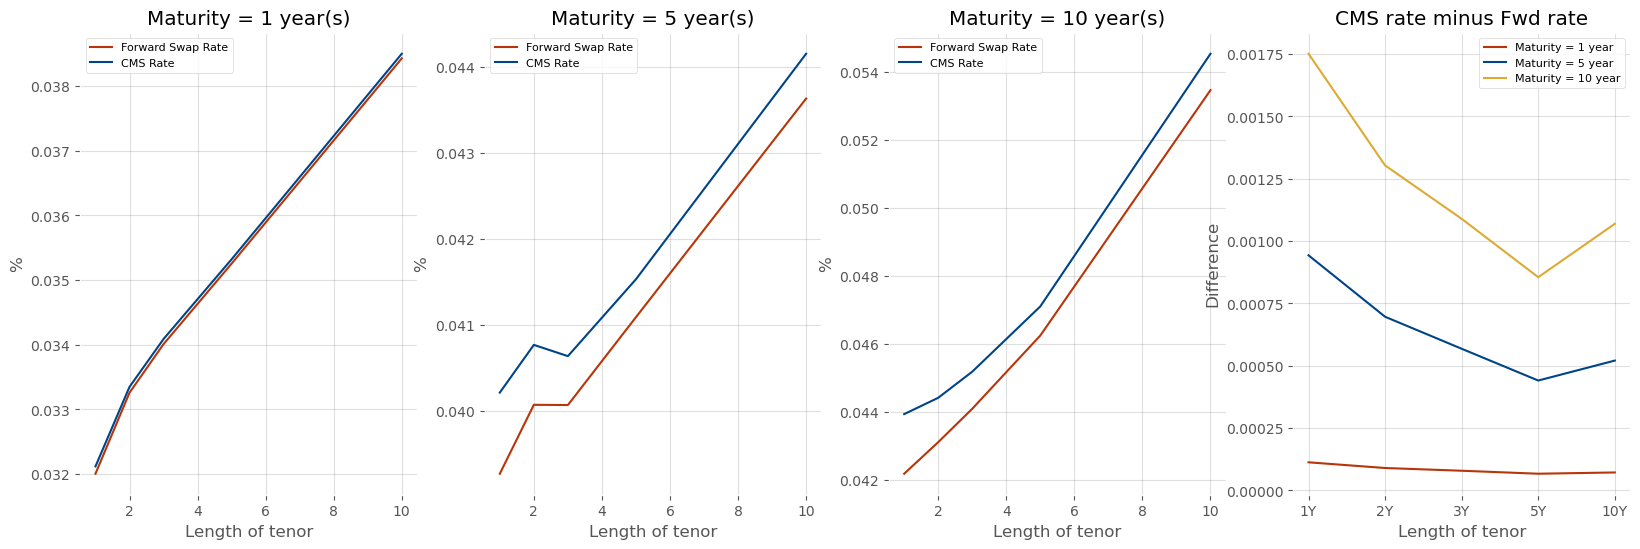

In [21]:
plt.figure(figsize=(20, 6))
x_label = [1,2,3,5,10]
t_label = [1,5,10]
for i in range(1,4):
    plt.subplot(1,4,i)
    plt.plot(x_label,df_new_CMS.loc[i*5-5:i*5-1,'Forward Rate'], label = "Forward Swap Rate",color = "#B73508")
    plt.plot(x_label,df_new_CMS.loc[i*5-5:i*5-1,'CMS Rate'], label = "CMS Rate", color = "#004488")
    plt.ylabel("%")
    plt.xlabel("Length of tenor")
    plt.title("Maturity = "+str(t_label[i-1])+" year(s)")
    plt.legend()
plt.subplot(1,4,4)
plt.plot(cms_1y["CMS-Fwd"], label = "Maturity = 1 year", color = "#B73508")
plt.plot(cms_5y["CMS-Fwd"], label = "Maturity = 5 year", color = "#004488")
plt.plot(cms_10y["CMS-Fwd"], label = "Maturity = 10 year", color = "#DDAA33")
plt.title("CMS rate minus Fwd rate")
plt.ylabel("Difference")
plt.xlabel("Length of tenor")
plt.legend()
plt.show()

It can be observed that:
- CMS rate is always higher than Forward rate.
- The difference between CMS rate and Forward rate increases as the tenor increases. 
- It can also be seen that the difference increases when the expiry date is later. 
- The magnitude of the difference increase dramatically from negligible amount to 0.0003 or 3 bips

One may say that the difference between CMS and Forward rate, and the difference accumulates when the product is longer or later.

This is indeed the case, as seen from the CMS formula above, there are additional integration terms after calculating the forward rate F. As the term is the present value of a swap product, the longer expiry and tenor would increase the value of the term.

The difference from convexity should not be ignored for products with similar or larger expiry than a 10y X 10y